In [1]:
#Ensemble Method: Combine different classifiers to create a new classifier that is better than each of the components
#ie: the whole is greater than the sum of the parts

#Majority voting: We run the different classifiers algorithms. The most class that is most predicted by all the 
# algo's is chose

# Example: for a row, algo1 -> class 1, algo2 -> class 1, algo3 -> class 2. In this case, we pick class 1 as the
# prediction




In [2]:
#Example that the majority voting works

from scipy.special import comb
import math

def ensembleError(n_classifier, error):
    kStart = int(math.ceil(n_classifier/2.0))
    
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) 
             for k in range(kStart, n_classifier+1)]
    return sum(probs)



In [3]:
#If there were 11 classifiers, with 0.25 error rate in classification, the ensemble method accuracy would be
# 1 - 0.034327
ensembleError(11, 0.25)

0.03432750701904297

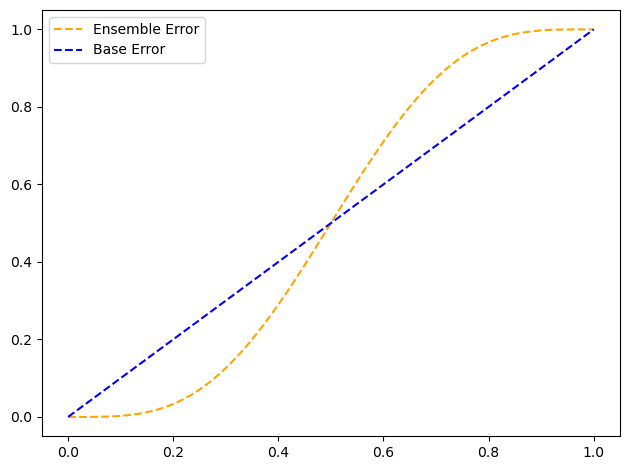

In [4]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)

ens_error = [ensembleError(n_classifier=7, error=x) for x in error_range]

plt.plot(error_range, ens_error, linestyle = '--', label = 'Ensemble Error', color = 'orange')
plt.plot(error_range, error_range, linestyle = '--', label = 'Base Error', color = 'blue')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [5]:
#So ensemble method is better when the base error

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import _name_estimators

import numpy as np
import operator 

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key,
            value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' "
                             f"or 'classlabel'"
                             f"; got (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and'
                             f' weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                               self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            
            # Collect results from clf.predict calls
            predictions = np.asarray([
                clf.predict(X) for clf in self.classifiers_
            ]).T
            
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(
                    np.bincount(x, weights=self.weights)
                ),
                axis=1, arr=predictions
            )
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0,
                               weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(
                        deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

            

In [21]:
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

iris = datasets.load_iris()

X, y = iris.data[50:, [1,2]], iris.target[50:]

le = LabelEncoder()

y = le.fit_transform(y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty = 'l2', C = 0.001, solver = 'lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p = 2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], 
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()], 
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

for clf, labels in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X = X_train, y = y_train, cv = 10, scoring = 'roc_auc')
    
    print(scores.mean(), scores.std())

0.9166666666666666 0.1536590742882148
0.8666666666666668 0.18333333333333332
0.85 0.13333333333333333


In [24]:
mv_clf = MajorityVoteClassifier( classifiers=[pipe1, clf2, pipe3])

scores = cross_val_score(estimator=mv_clf, X= X_train, y=y_train, cv = 10, scoring = 'roc_auc')

In [25]:
scores.mean(), scores.std()

(0.9833333333333334, 0.04999999999999999)

In [26]:
#Majority Vote Classifier on test data
y_pred = mv_clf.predict(X_train)

sum(y_pred == y_test)/len(y_pred)


AttributeError: 'MajorityVoteClassifier' object has no attribute 'classifiers_'

In [27]:
# Stacking
# For a row, or a data point, bunch of estimators do their job. Then, another estimator takes all the inputs, and
# generates another, final prediction

In [ ]:
# Bagging
# Same as majority, but instead of using the same dataset to fit individual classifiers, we draw samples with 
# replacements from initial training dataset


In [31]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash',
                   'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']

# Dropping all rows with class = 1
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values


In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [34]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)

bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, 
                        bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)



In [35]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred  = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

treeTrain = accuracy_score(y_train, y_train_pred)
testTrain = accuracy_score(y_test, y_test_pred)

print(treeTrain, testTrain)

1.0 0.8333333333333334


In [36]:
#Using bagging

bag = bag.fit(X_train, y_train)

y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

print(accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred, y_test))

/home/pranav/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0 0.9166666666666666


In [ ]:
#Boosting -> Adaptive Boosting

# In boosting, we first use simple base classifiers/weak learners, only slightly better than random guessing
# Focus on training examples that are hard to classify, let weak learners subsequently learn from misclassified 
# training examples



In [37]:
#AdaBoost using scikit learn

from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              random_state=1, 
                              max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print(accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred, y_test))




0.9157894736842105 0.875


In [38]:
ada = ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

print(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))

/home/pranav/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0 0.9166666666666666


In [39]:
# XGBoost
# Builds a series of trees. The subsequent tree is attatched to the previous trees misclassification/error
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators = 1000, learning_rate = 0.01, max_depth=4, random_state=1, 
                          use_label_encoder=False)

gbm = model.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

print(accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred, y_test))

0.968421052631579 0.9166666666666666


/home/pranav/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
